# n-Armed Bandit Problem

The problem statement is as follows, consider number of levers on slot machine for example. Each lever has a reward but the agent can only estimate the value of reward it receives. After some trial and errors agent should pick a lever that gives him the most reward. 

The question that might arise is that how should we keep the balance between exploiting (picking the lever that we think is the best) and exploring (pulling other levers to gain better estimation).

## Action-Value Method

The first approach to this problem is to take an action-value method, this means that giving value to each action so that we could keep track of each action and decide whether choosing them or not in the future. Here we do it by averaging enough samples so that by the rule of big numbers the estimation will approach the real value, and then choose the best estimation. One natural way to estimate this is by averaging the rewards actually received:

\begin{equation*}
Q_t(a) \doteq \frac{sum\space of\space rewards\space when\space a\space taken\space prior\space to\space t}{number\space of\space times\space a\space taken\space prior\space to\space t\space} = \frac{\sum_{i=1}^{t-1} {R_i \cdot {\mathbb{1}}_{A_i = a}}}{\sum_{i=1}^{t-1} {{\mathbb{1}}_{A_i = a}}}
\end{equation*}

which ${\mathbb{1}}_{predicter}$ indicates that whether in time $t$ action $a$ was picked or not. If it was then use it in averaging.

In [2]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from math import pow, e
import sys, warnings
if not sys.warnoptions: warnings.simplefilter("ignore")
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10, 8)
%load_ext autoreload
%autoreload 2
np.random.seed(7) # for reproduction

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


First, we define our environment which consists of the number of arms, mean value and variance for making true reward of each arm. A reward is returned with a normal distribution with mean q∗(chosen) and variance 1.

In [13]:
class Environment():
    
    def __init__(self, armCount = 10, mean = 0.0, stdev = 1.0):
        
        self.armCount = armCount
        self.arms = np.arange(armCount)
        
        self.qStar = np.random.normal(mean, stdev, armCount)
        self.optimalChoice = np.argmax(self.qStar)
            
    def reward(self, chosen):
        return np.random.normal(self.qStar[chosen], scale = 1.0)

In [14]:
env = Environment()

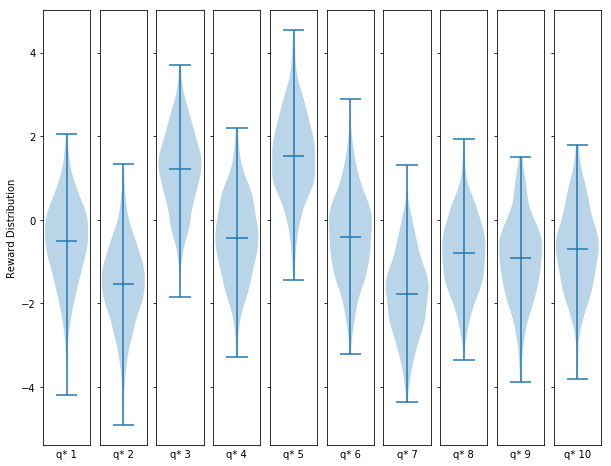

In [15]:
fig, axes = plt.subplots(1, env.armCount, sharey=True)
axes = axes.ravel()

for k, v in enumerate(env.qStar):
    ax = axes[k]
    ax.set_xticks([])
    data = np.random.normal(v, size=500)
    ax.violinplot(data, showmeans=True)
    ax.set_xlabel('q* ' + str(k + 1))
    if k == 0: ax.set_ylabel('Reward Distribution')

Then we define our first agent. It simply just choose the best arm that based on values of its estimation.

In [16]:
class GreedyAgent():
    
    def __init__(self, armCount):
        self.values = np.zeros(armCount) # estimated reward of each action
        self.pullCount = np.zeros(armCount) # number of pull for each lever
        self.armCount = armCount # number of arms

    def __repr__(self):
        return "Greedy"

    def selectArm(self):
        return np.argmax(self.values)

    def update(self, i, reward):
        self.pullCount[i] += 1
        count = self.pullCount[i]
        value = self.values[i]
        # newEstimate = oldEstimate + step_size * (target - oldEstimate)
        self.values[i] = value + (1/count) * (reward - value)

    def refresh(self):
        self.values.fill(0)
        self.pullCount.fill(0)
    

In [17]:
agents = [GreedyAgent(env.armCount)]

The default is each agent is pulling the levers 1000 time and we are repeating this test  2000 time then we take an average of this tests for further illustration.

In [25]:
class Sampling():
    
    def __init__(self, env, agents, play = 1000, run = 2000):
        self.env = env
        self.agents = agents
        self.play = play
        self.run = run
        self.colors = ['black', 'red', 'green', 'blue', 'magenta', 'cyan']
        self.rewardData = np.zeros((len(agents), play, run))
        self.optimalityData = np.zeros((len(agents), play, run))
        
    def start(self):
        
        for r in tqdm(range(self.run)):
            for p in range(self.play):
                for a in range(len(self.agents)):
                    choosen = self.agents[a].selectArm()
                    reward = self.env.reward(choosen)
                    self.agents[a].update(choosen, reward)
                    self.rewardData[a][p][r] += reward
                    if self.env.optimalChoice == choosen:
                        self.optimalityData[a][p][r] += 1
        
            for a in range(len(agents)):
                self.agents[a].refresh()

        

In [19]:
sample = Sampling(env, agents)
sample.start()

100%|██████████| 2000/2000 [00:19<00:00, 100.81it/s]


In [20]:
def plotResults(sample):
    rewardMean = np.mean(sample.rewardData, axis=2)
    optimalityMean = np.mean(sample.optimalityData, axis=2)
    time = np.array(list(range(sample.play)))

    for a in range(len(sample.agents)):
        plt.subplot(2, 1, 1)
        plt.plot(time, optimalityMean[a], '-o'
                , color=sample.colors[a], markersize=0.7, lw=1.5, label=str(sample.agents[a]))
        plt.ylabel('% Optimal Action')

        plt.subplot(2, 1, 2)
        plt.plot(time, rewardMean[a], '-o'
                , color=sample.colors[a], markersize=0.7, lw=1.5, label=str(sample.agents[a]))
        plt.ylabel('Average Reward')
        plt.xlabel('play')

    plt.legend(loc='best', fancybox=True)
    plt.show()

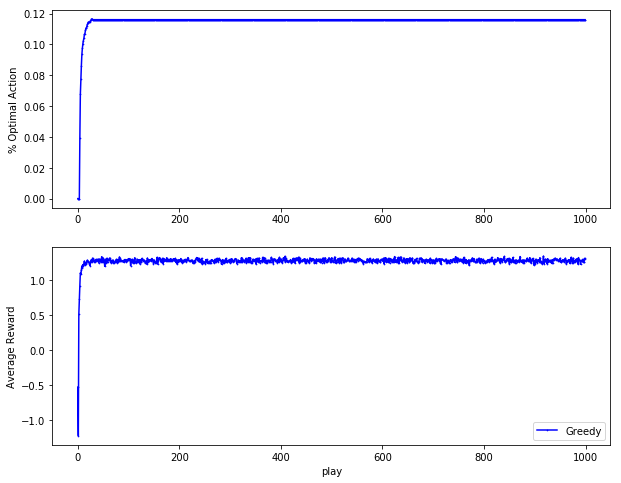

In [21]:
plotResults(sample)

why this agent is doing so poorly is because it just thinks that the first action is the best (in some cases it is) and always exploit it and never explore other options. The simple solution is to define a new agent that explore with the probabilty of epsilon.

In [22]:
class EpsilonGreedyAgent():
    
    def __init__(self, armCount, epsilon = 0.1):
        self.values = np.zeros(armCount)
        self.pullCount = np.zeros(armCount)
        self.choice = np.arange(armCount)
        self.armCount = armCount
        self.epsilon = epsilon

    def __repr__(self):
        return "Epsilon= " + str(self.epsilon)

    def selectArm(self):
        if np.random.rand() > self.epsilon: # Exploit
            return np.argmax(self.values)
        else: # Explore
            return np.random.choice(self.choice)

    def update(self, i, reward):
        self.pullCount[i] += 1
        count = self.pullCount[i]
        value = self.values[i]
        # newEstimate = oldEstimate + step_size * (target - oldEstimate)
        self.values[i] = value + (1/count) * (reward - value)

    def refresh(self):
        self.values.fill(0)
        self.pullCount.fill(0)

In [26]:
agents = [EpsilonGreedyAgent(env.armCount, 0.1), EpsilonGreedyAgent(env.armCount, 0.01), GreedyAgent(env.armCount)]
sample = Sampling(env, agents)
sample.start()

100%|██████████| 2000/2000 [00:56<00:00, 35.47it/s]


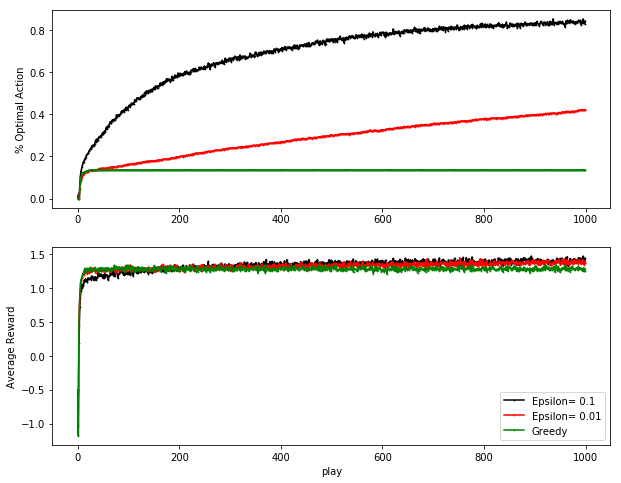

In [27]:
plotResults(sample)

One downside to epsilon greedy is that it continues to explore with the same probability as before no matter how many examples it sees, the solution for this problem is that we can decay the value of epsilon over time so this will let the agent to settle on an optimal solution and continue to exploit it. New epsilon value with respect to time is:

\begin{equation*}
{\epsilon}_t = \frac{1}{1+(t*decay)}
\end{equation*}

In [35]:
class EpsilonDecayAgent():
    
    def __init__(self, armCount, epsilon = 0.1, decay = 0.1):
        self.values = np.zeros(armCount)
        self.pullCount = np.zeros(armCount)
        self.choice = np.arange(armCount)
        self.armCount = armCount
        self.initEpsilon = epsilon # keep inital epsilon
        self.epsilon = epsilon
        self.decay = decay # decay rate
        self.time = 0 # keep track of time

    def __repr__(self):
        return "Epsilon Decay Inital Epsilon = " + str(self.initEpsilon)

    def selectArm(self):
        self.epsilon = 1/(1+self.time*self.decay)
        self.time += 1
        if np.random.rand() > self.epsilon: # Exploit
            return np.argmax(self.values)
        else: # Explore
            return np.random.choice(self.choice)

    def update(self, i, reward):
        self.pullCount[i] += 1
        count = self.pullCount[i]
        value = self.values[i]
        # newEstimate = oldEstimate + step_size * (target - oldEstimate)
        self.values[i] = value + (1/count) * (reward - value)

    def refresh(self):
        self.values.fill(0)
        self.pullCount.fill(0)
        self.epsilon = self.initEpsilon
        self.time = 0

In [36]:
agents = [EpsilonGreedyAgent(env.armCount, 0.1), EpsilonDecayAgent(env.armCount, 0.1, 0.1)]
sample = Sampling(env, agents)
sample.start()

100%|██████████| 2000/2000 [00:48<00:00, 41.09it/s]


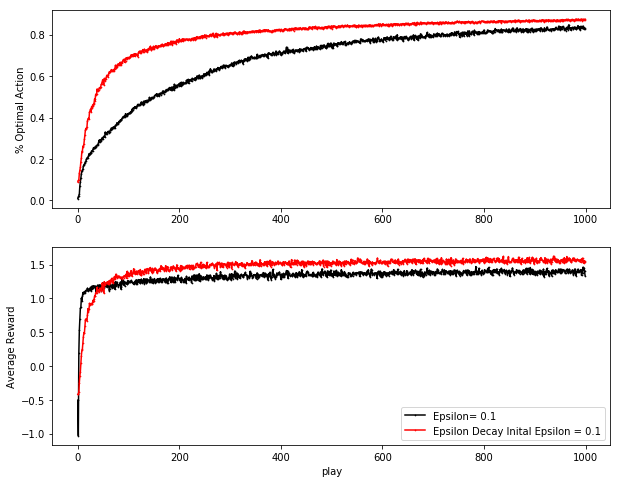

In [37]:
plotResults(sample)

Another weakness to this approch is that when it explores it chooses equally among all actions. This means that it is as likely to choose the worst-appearing action as it is to choose the next-to-best action. We can choose other options with probability based on their value.

## Softmax Action Selection

This approach is called the softmax action selection rule, a common way to achieve this is by using Boltzmann distribution.
Probability of choosing action $a$ is:

\begin{equation*}
{\pi}_t(a) = \frac{{e^{Q_t(a)}}/{\tau}}{\sum_{b=1}^n {e^{Q_t(b)}}/{\tau}}
\end{equation*}

where ${\tau}$ is a positive parameter called the temperature. High temperatures cause the actions to be all (nearly) equiprobable (it's like picking action one after another no matter what the reward is). Low temperatures cause a greater difference in selection probability(works nearly same as epsilon greedy agent). 

In [83]:
class SoftmaxAgent():
    
    def __init__(self, armCount, temp = 0.1):
        self.values = np.zeros(armCount)
        self.pullCount = np.zeros(armCount)
        self.choice = np.arange(armCount)
        self.armCount = armCount
        self.temp = temp
        self.valueExp = np.ones(armCount) # save e ^ value/temp
        self.sumExp = 1 * self.armCount # sum of all e ^ value/temp 
                                            # (in beggining all of them are 1)
        self.prob = self.valueExp / self.armCount 

    def __repr__(self):
        return "Softmax: " + str(self.temp)

    def selectArm(self):
        return np.random.choice(self.choice, p=self.prob) # choose arm according to 
                                                            # its probability

    def update(self, i, reward):
        self.pullCount[i] += 1
        count = self.pullCount[i]
        value = self.values[i]
        # updating value estimation and probabilties
        self.sumExp -= self.valueExp[i]
        self.values[i] = value + (1/count) * (reward - value) #* (1 - prob)
        m = self.values[i] / self.temp
        self.valueExp[i] = pow(e,m)
        self.sumExp += self.valueExp[i]
        self.prob = self.valueExp / self.sumExp
        

    def refresh(self):
        self.values.fill(0)
        self.pullCount.fill(0)
        self.valueExp.fill(1.0)
        self.sumExp = 1 * self.armCount
        self.prob.fill(1/self.armCount)

In [39]:
agents = [SoftmaxAgent(env.armCount, 0.25), EpsilonGreedyAgent(env.armCount, 0.04), EpsilonDecayAgent(env.armCount, 0.1, 0.1)]
sample = Sampling(env, agents)
sample.start()

100%|██████████| 2000/2000 [02:43<00:00, 12.24it/s]


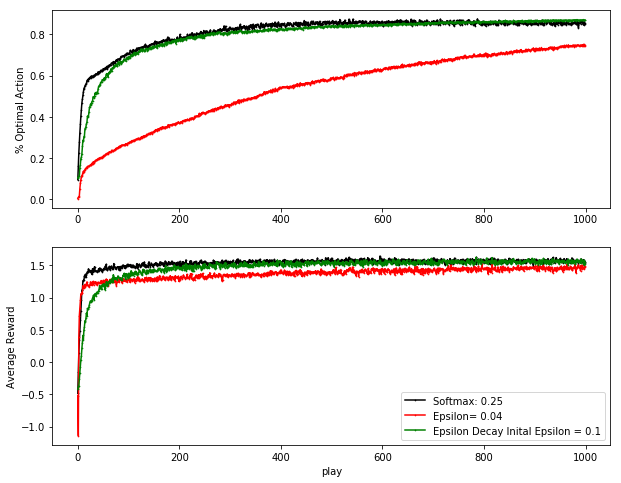

In [40]:
plotResults(sample)

## Tracking a Nonstationary Problem

To this point we have used sample-average method to update our value estimation, but this is going to work only on a stationary problem. What if our environment change the value of reward slightly over time? 

In [69]:
class NonStationaryEnvironment():
    
    def __init__(self, armCount = 10, mean = 0.0, stdev = 1.0, randomWalk = 0.01):
        
        self.armCount = armCount
        self.arms = np.arange(armCount)
        
        self.qStar = np.zeros(armCount)
        self.qStar.fill(1/armCount) # all reward are equal initialy
        self.optimalChoice = np.argmax(self.qStar)
        
        self.randomWalk = randomWalk # stddiv for random walk
            
    def reward(self, chosen):
        self.qStar += np.random.normal(0.0, scale = self.randomWalk)
        self.optimalChoice = np.argmax(self.qStar)
        return np.random.normal(self.qStar[chosen], scale = 1.0)

In [70]:
nsEnv = NonStationaryEnvironment()

Due to the fact that now our environment is non-stationary so its irrational to give more weight to long-past rewards instead of recent rewards. The solution is to choose a step-size parameter, $\alpha$ to updating value estimation of our agent. But finding a step size that leads us to convergence must meet these stochastic approximation theory conditions:

\begin{equation*}
{\sum_{n=1}^{\infty} {{\alpha}_n(a)}} = \infty
\space \space and \space \space
{\sum_{n=1}^{\infty} {{{\alpha}_n}^2(a)}} < \infty
\end{equation*}

The first equation is to making sure that step sizes are large enough to prevent facing any initial conditions nor random fluctuations. The latter one guarantees that eventually the steps become small enough to assure convergence.
For the case of sample-averaging, $\alpha = 1/n$ (n being the number of arms) is satisfying both conditions. But constant step size rejects the second condition thus never completely converge but continue to vary in response to the most recently received rewards.

Both sample-averaging and constant step size are biased for the sample-average methods, the bias disappears once all actions have been selected at least once, but for methods with constant step size, the bias is permanent, though decreasing over time, $\alpha$ weights recent observations more than previous ones. Our value estimation is calculated as follows:

\begin{equation*}
Q_{t+1} = (1-\alpha)^n Q_1 + {\sum_{i=1}^{n} {\alpha(1-\alpha)^{n-i}*Reward}}
\end{equation*}

In [71]:
class EpsilonGreedyAgent2():
    
    def __init__(self, armCount, epsilon = 0.1, alpha = None):
        self.values = np.zeros(armCount)
        self.pullCount = np.zeros(armCount)
        self.choice = np.arange(armCount)
        self.armCount = armCount
        self.epsilon = epsilon
        self.alpha = alpha
        if self.alpha is None: self.alpha = 1 / self.armCount # default alpha = 1/n

    def __repr__(self):
        return "Epsilon= " + str(self.epsilon) + " Alpha=  " + str(self.alpha)

    def selectArm(self):
        if np.random.rand() > self.epsilon: # Exploit
            return np.argmax(self.values)
        else: # Explore
            return np.random.choice(self.choice)

    def update(self, i, reward):
        self.pullCount[i] += 1
        count = self.pullCount[i]
        value = self.values[i]
        # newEstimate = oldEstimate + step_size * (target - oldEstimate)
        self.values[i] = value + (self.alpha) * (reward - value)

    def refresh(self):
        self.values.fill(0)
        self.pullCount.fill(0)

In [72]:
agents = [EpsilonGreedyAgent(env.armCount, 0.1), EpsilonGreedyAgent2(env.armCount, 0.1, 0.1)]
sample = Sampling(nsEnv, agents, play = 10000) 
sample.start()

100%|██████████| 2000/2000 [11:09<00:00,  2.99it/s]


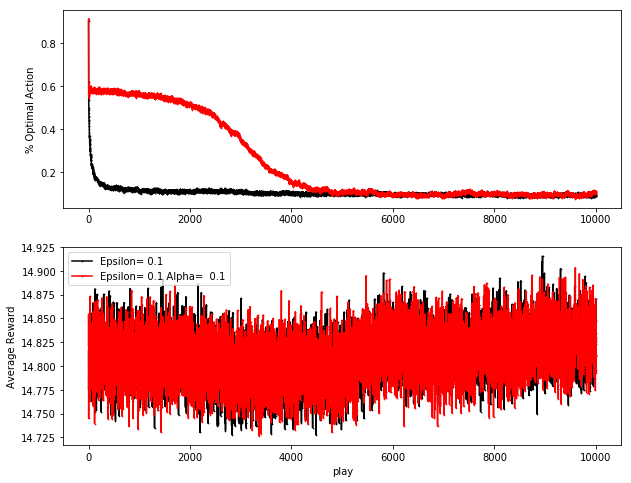

In [73]:
plotResults(sample)

The constant-step-size helps the agent outperform average-sample agent. Overall, none of them are effective in the end, at first all rewards start from zero but soon after they are out of control and unpredictable thus resulting in failure for both agents.

## Optimistic Initial Values

We can force our agent to explore in the beginning and then let it exploit (either Greedy or EpsilonGreedy). But when our environment is non-stationary this is not a good idea because maybe in future there will be a better action due to changing situation. But for now we are sampling stationary cases. If we assign our initial action values to 5 instead of zero, recalling that our environment reward mean is zero and variance is one. This claim is really optimistic, but this optimism encourages action-value methods to explore. Whichever actions are initially selected, the reward is less than the starting estimates; the learner switches to other actions, being “disappointed” with the rewards it is receiving. The result is that all actions are tried several times before the value estimates converge. The system does a fair amount of exploration even if greedy actions are selected all the time.

In [54]:
class OptimisticAgent():
    
    def __init__(self, armCount, epsilon = 0.1, alpha = None, initVal = 5):
        self.values = np.zeros(armCount)
        self.initVal = initVal # initial value given for OptimisticAgent
        self.values.fill(self.initVal)
        self.pullCount = np.zeros(armCount)
        self.choice = np.arange(armCount)
        self.armCount = armCount
        self.epsilon = epsilon
        self.alpha = alpha
        if self.alpha is None: self.alpha = 1 / self.armCount # default alpha = 1/n

    def __repr__(self):
        return "Optimistic " + (("Epsilon= " + str(self.epsilon)) if self.epsilon > 0 else "Greedy")

    def selectArm(self):
        if np.random.rand() > self.epsilon: # Exploit
            return np.argmax(self.values)
        else: # Explore
            return np.random.choice(self.choice)

    def update(self, i, reward):
        self.pullCount[i] += 1
        count = self.pullCount[i]
        value = self.values[i]
        # newEstimate = oldEstimate + step_size * (target - oldEstimate)
        self.values[i] = value + (self.alpha) * (reward - value)

    def refresh(self):
        self.values.fill(self.initVal)
        self.pullCount.fill(0)

In [55]:
agents = [OptimisticAgent(env.armCount, 0.1), OptimisticAgent(env.armCount, 0.0), EpsilonDecayAgent(env.armCount, 0.1, 0.1)]
sample = Sampling(env, agents)
sample.start()

100%|██████████| 2000/2000 [01:03<00:00, 31.60it/s]


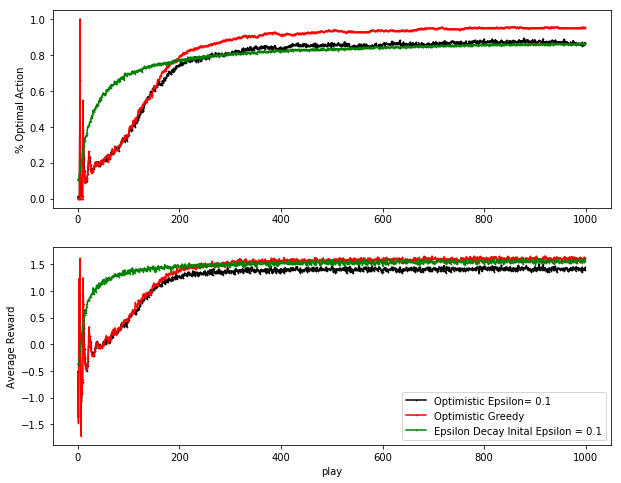

In [56]:
plotResults(sample)

Spikes in the start of optimistic agents are caused by exploration whenever agent is pulling an optimal lever it recives a lot of initial rewards compare to realistic agent and also there is chance to pull the worst lever causing in losing avarage reward, this fluctuation is causing optimistic agents to do poorly due to their exploring,  but later on, after discovering the best action, now they are exploiting it. The reason why the greedy optimistic agent is doing better is that this environment is stationary so further exploring is not beneficial.

Both optimistic agents have a constant step size of 0.1, as said before this indicate that they both have a bias toward later rewards that they had received, and we can't use sample-average approach due to the fact they do poorly on non-stationary environments. We can add a factor ($\overline{\rm o_n}$) to our constant step size which is converging from 1 to $\alpha$ itself:

\begin{equation*}
\beta_n \doteq \alpha \space / \space \overline{\rm o_n}
\\
\overline{\rm o_n} \doteq \overline{\rm o_{n-1}} + \alpha(1-\overline{\rm o_{n-1}}), \space \space for \space n \geq 0 \space with \space \overline{\rm o_0} \doteq 0
\end{equation*}

In [74]:
class OptimisticAgent2():
    
    def __init__(self, armCount, epsilon = 0.1, alpha = None, initVal = 5):
        self.values = np.zeros(armCount)
        self.initVal = initVal # initial value given for OptimisticAgent
        self.values.fill(self.initVal)
        self.pullCount = np.zeros(armCount)
        self.choice = np.arange(armCount)
        self.armCount = armCount
        self.epsilon = epsilon
        self.alpha = alpha
        if self.alpha is None: self.alpha = 1 / self.armCount # default alpha = 1/n
        self.oBar = self.alpha # initial oBar is 0 leading oBar1 to be alpha itself
        

    def __repr__(self):
        return "Optimistic " + (("Epsilon= " + str(self.epsilon)) if self.epsilon > 0 else "Greedy")

    def selectArm(self):
        if np.random.rand() > self.epsilon: # Exploit
            return np.argmax(self.values)
        else: # Explore
            return np.random.choice(self.choice)

    def update(self, i, reward):
        self.pullCount[i] += 1
        count = self.pullCount[i]
        value = self.values[i]
        # newEstimate = oldEstimate + step_size * (target - oldEstimate)
        self.values[i] = value + (self.alpha / self.oBar) * (reward - value)
        self.oBar += self.alpha * (1 - self.oBar)

    def refresh(self):
        self.values.fill(self.initVal)
        self.pullCount.fill(0)

In [80]:
agents = [OptimisticAgent2(env.armCount, 0, 0.1), OptimisticAgent(env.armCount, 0, 0.1)]
sample = Sampling(env, agents)
sample.start()

100%|██████████| 2000/2000 [00:45<00:00, 44.31it/s]


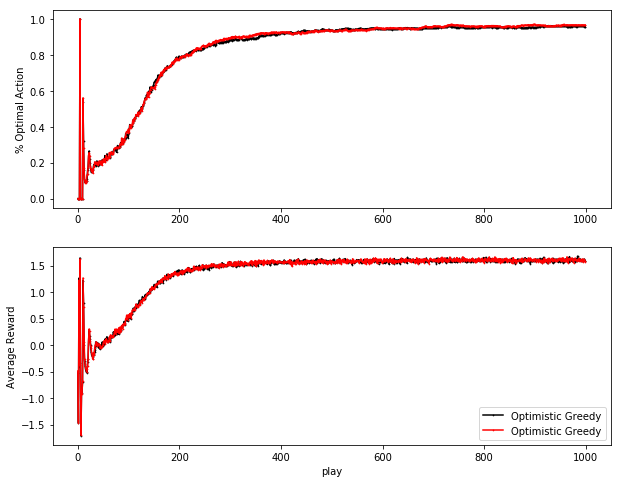

In [81]:
plotResults(sample)

(?)

## Upper-Confidence-Bound Action Selection

The problem with epsilon greedy agents is that they choose among other action indiscriminately, with no preference for those that are nearly greedy or particularly uncertain. 

In [89]:
class UCBAgent():
    
    def __init__(self, armCount, c = 2):
        self.values = np.zeros(armCount)
        self.pullCount = np.zeros(armCount)
        self.armCount = armCount
        self.c = c
        self.time = 0 # keeping track of time

    def __repr__(self):
        return "UCB: " + str(self.c)

    def selectArm(self):
        self.time += 1
        ubc = self.values + self.c * np.sqrt(np.log(self.time)/self.pullCount)
        return np.argmax(ubc)

    def update(self, i, reward):
        self.pullCount[i] += 1
        count = self.pullCount[i]
        value = self.values[i]
        self.values[i] = value + (1/count) * (reward - value)
        

    def refresh(self):
        self.values.fill(0)
        self.pullCount.fill(0)
        self.time = 0

In [95]:
agents = [UCBAgent(env.armCount, 2), EpsilonGreedyAgent(env.armCount, 0.1)]
sample = Sampling(env, agents)
sample.start()

100%|██████████| 2000/2000 [01:05<00:00, 30.66it/s]


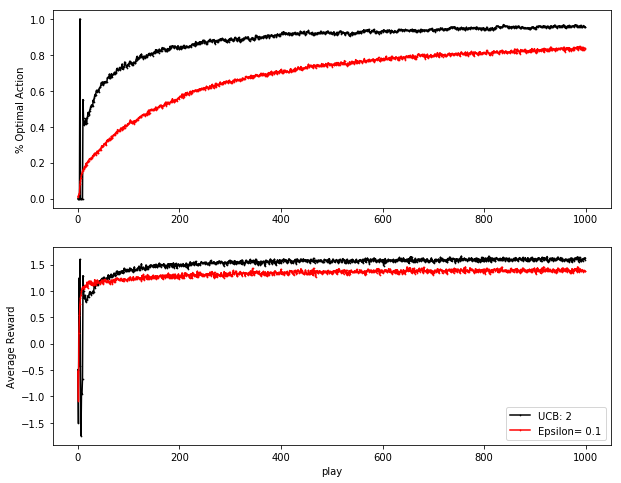

In [96]:
plotResults(sample)

## Gradient Bandit Algorithms

## Reinforcement Comparison

## Pursuit Methods